<h1 style="text-align:center;">Intelligent Signal Processing: Exercise-3 Notebook</h1>

In this project, we use audio steganography methods to decode data that was hidden in audio files, and also create our very own audio steganography algorithm to hide secret data within a audio file.

First, we import all the neccesary libraries. 
The `wave` library is used for reading and writing `.wav` audio files. The `numpy` library is used for processing large arrays of sound data. `matplotlib.pyplot` is used for plotting the sound data. The `cryptography` library is used in creating our own steganography method. Finally, `IPython.display` is used to display and play the decoded audio file from Task-2.

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from cryptography.fernet import Fernet

Now, we create two utility functions for reading and writing `.wav` files more easily.

In [2]:
# function to read sound data from a .wav file
def readWAV(filename:str, dtype=np.uint8):
    with wave.open(filename, mode='rb') as f:
        audio_channels = f.getnchannels()
        sample_width_in_bytes = f.getsampwidth()
        samplig_freq = f.getframerate()
        num_frames = f.getnframes()
        sound_frames = f.readframes(num_frames)
    # print("Reading an audio file with %d-channels, %d-bytewidth, fs=%d, and num_frames=%d" % (audio_channels, sample_width_in_bytes, samplig_freq, num_frames))
    sound_data = np.frombuffer(sound_frames, dtype=dtype, count=-1)
    return (audio_channels, sample_width_in_bytes, samplig_freq, num_frames), sound_data

# function to write sound data into a .wav file
def writeWAV(output_filename:str, sound_data:np.ndarray, metadata):
    with wave.open(output_filename, mode='wb') as f:
        f.setnchannels(metadata[0])
        f.setsampwidth(metadata[1])
        f.setframerate(metadata[2])
        f.setnframes(metadata[3])
        f.writeframes(sound_data.tobytes())
    return

## Task-1:

Now, we create the function to decode the LSB-steganographed hidden message in Task-1. First, this function extracts the audio data and pads it so that it becomes divisible by 8. Then, it extracts the LSB from each audio data-point and packs exactly 8 of them into a byte. Finally, it cuts off the message at the end-of-message sequence (which is '###') and returns the decoded message.

In [3]:
# function to decode the LSB-encoded secret message -- in text format
def decodeLSBSteganography(filename:str):
    # read the sound-file and prepare all the required metadata
    metadata, sound_data = readWAV(filename=filename)
    num_datapoints = sound_data.shape[0]

    # pad the sound-data array if it is determined that the bit packing might cause trouble
    if num_datapoints%8 != 0:
        pad = (8 - num_datapoints%8)
        num_datapoints += pad
        sound_data = np.pad(sound_data, pad_width=(0,pad), constant_values=0)
    
    # pack the bit-array into bytes and decode the secret message
    message_bits = (sound_data & 1).reshape(num_datapoints // 8, 8)
    chararray = np.packbits(message_bits)
    string = "".join(chr(x) for x in chararray)
    decoded = string.split('###')[0]
    return decoded

Here, we print out the message.

In [4]:
print("\n\nDecoded message:", decodeLSBSteganography('./sounds/Ex3_sound1.wav'), "\n\n")



Decoded message: Mom I will not be home for supper 




## Task-2

In this task, we need to first understand which audio file contains the secret data. For this, we need to plot the frequency spectrum of all three given audio files first. The following function achieves that excat purpose.

In [5]:
# function to plot the audio waveform and it's corresponding frequency spectrum
def frequencyPlot(filename:str):
    # read the sound-file and prepare all the required metadata
    metadata, sound_data = readWAV(filename=filename, dtype=np.int16)
    sampling_rate = metadata[2]
    num_datapoints = metadata[3]

    # normalize the data to get best quality results
    normalizer = np.max(np.abs(sound_data))
    signal = sound_data / normalizer

    # get the frequency-domain representation of the normalized audio signal -- using FFT
    Signal = np.fft.fft(signal)
    abs_frequencies = np.abs(np.fft.fftfreq(num_datapoints, d=1/sampling_rate))

    # plot the audio signal -- both the time-domain and frequency-domain representations
    fig, (axt, axf) = plt.subplots(2, 1, constrained_layout=1, figsize=(11.8,3))
    axt.plot(signal, lw=0.15) ; axt.grid(1)
    axt.set_xlabel('Time-->')
    axt.set_ylabel('Amplitude-->')
    axf.plot(abs_frequencies, Signal.real, lw=0.15) ; axf.grid(1)
    axf.set_xlabel('Audio Frequency-->')
    axf.set_ylabel('Amplitude-->')
    plt.show()

Next, we plot and see which audio file contains the secret message. Note that the audio plot here is normalized.

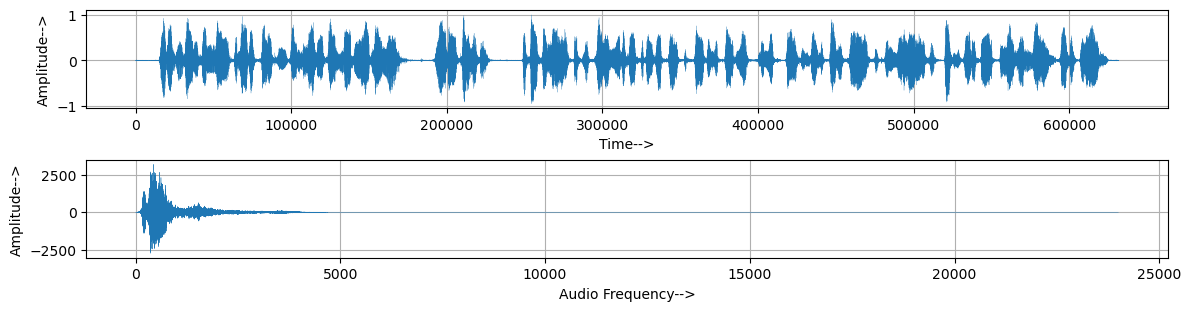

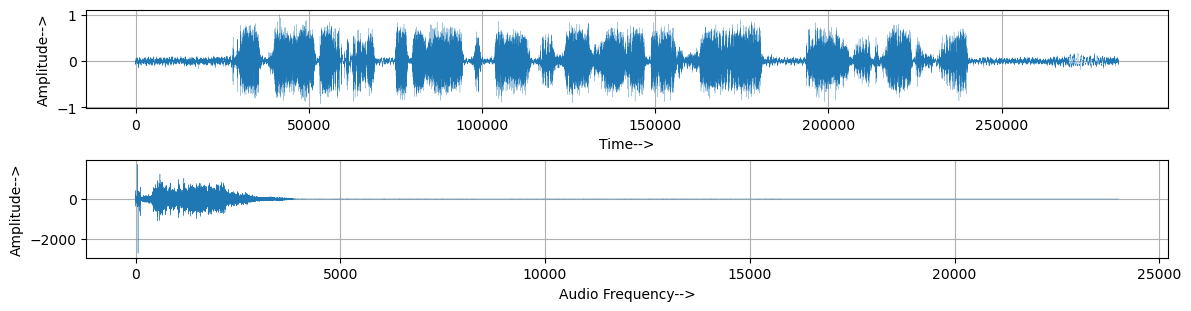

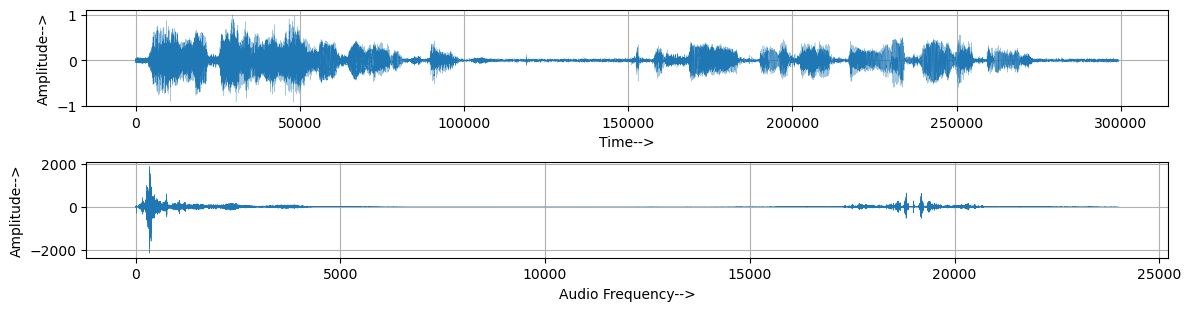

In [6]:
frequencyPlot('./sounds/Ex3_sound2.wav')
frequencyPlot('./sounds/Ex3_sound3.wav')
frequencyPlot('./sounds/Ex3_sound4.wav')

From the frequency spectrum, it is clear that the third audio file (Ex2_sound4.wav) contains our secret message in the ultrasound-range of frequencies.

Now, we create a function to move this secret message to the audible range of frequencies. This is easy to do with a simple pointwise multiplication with a phase-shift factor. After moving this message to the audible range of frequencies, we then remove all the frequencies other than it after applying FFT to the audio signal, before using inverse-FFT to get a clean version of our secret audio message.

In [7]:
# function to decode the amplitude-modulated secret code -- in audio format
def decodeAmplitudeModulation(filename:str, offset_frequency):
    # read the sound-file and prepare all the required metadata
    metadata, sound_data = readWAV(filename=filename, dtype=np.int16)
    sampling_rate = metadata[2]
    num_datapoints = metadata[3]
    
    # create a phase-shift factor for all datapoints
    phase_shift = np.exp(-2j * np.pi * offset_frequency * np.arange(num_datapoints)/sampling_rate)
    
    # now, get the frequency-domain representation of the audio file and remove the noise -- which happens to be the original audio after the phase shifting is done
    frequency_domain_sound = np.fft.fft(sound_data * phase_shift)
    abs_frequencies = np.abs(np.fft.fftfreq(num_datapoints, d=1/sampling_rate))
    frequency_domain_sound[abs_frequencies > 5000] = 0              # anything above 5kHz is not needed
    sound_data_decoded = np.fft.ifft(frequency_domain_sound).real   # take only the real values

    # finally, write the decoded audio into a new .wav file
    writeWAV(filename.split('/')[-1].split('.')[0] + 'decoded.wav', sound_data_decoded.astype(np.int16), metadata=metadata)

Now, we decode the audio and plot the resulting secret audio signal. The decoded result is saved on the system as a `.wav` audio file.

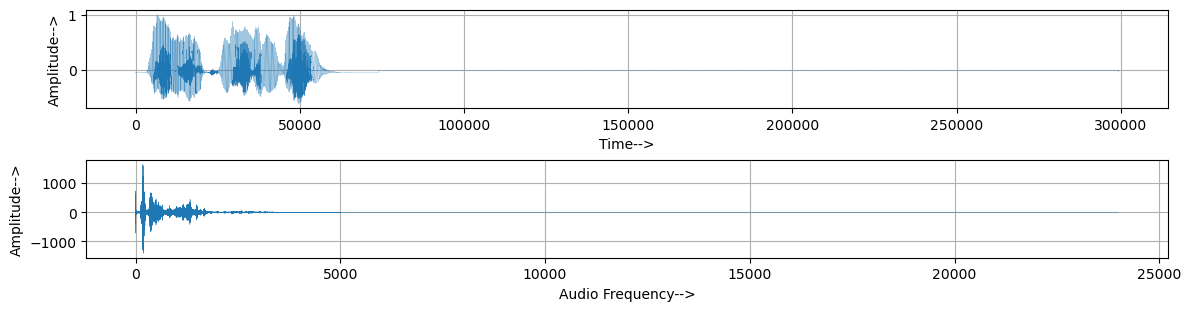

In [8]:
decodeAmplitudeModulation('./sounds/Ex3_sound4.wav', 19000)
frequencyPlot('Ex3_sound4decoded.wav')


We can also play this decoded audio, giving us the secret 4-digit number: 1891.

In [9]:
audio_player = Audio('Ex3_sound4decoded.wav')
display(audio_player)

## Task-3

In this task, we create our very own LSB-encoding based steganography method by mixing LSB-encoding with cryptography. Our steganography method consists of first generating a cryptography key. We then encrypt our initial secret message with said key, and then concatenate the length of the encrypted message with the encrypted message. Finally, we use the concatenated result as a secret message that is embedded into the given audio file using LSB-encoding based steganography.

The decoding function just reverses all of this, by first getting the encrypted message length from the first 2-bytes of the normally LSB-decoded byte-array and then decrypting the message using the secret key (which needs to be shared beforehand).

In [10]:
# function to encode the given message into a target audio file using a custom steganography scheme
def encodeCustomStego(filename:str, message:str):
    # read the sound-file and prepare all the required metadata
    metadata, sound_data = readWAV(filename=filename, dtype=np.uint8)

    # generate encryption key and initialize the encryptor
    encryption_key = Fernet.generate_key()
    encryptor_object = Fernet(key=encryption_key)

    # encrypt the message
    encrypted_message = encryptor_object.encrypt(bytes(message, encoding='UTF-8'))
    encrypted_bytes = np.frombuffer(encrypted_message, dtype=np.uint8)
    encrypted_length = np.frombuffer(np.array(encrypted_bytes.shape[0], dtype=np.uint16).tobytes(), dtype=np.uint8)

    # append the message length on top of the encrypted message and get the final bytes/bits for embedding into target audio
    final_stego_message = np.concatenate((encrypted_length, encrypted_bytes))
    final_bits = np.unpackbits(final_stego_message)
    encoded_sound_data = sound_data.copy()
    
    # embed the bytes/bits into the audio stream
    for i in range(final_bits.shape[0]):
        sound_bits = np.unpackbits(encoded_sound_data[i])
        sound_bits[7] = final_bits[i]
        encoded_sound_data[i] = np.packbits(sound_bits)[0]
    
    # finally, write the encoded audio into a new .wav file and return the encryption-key
    writeWAV(filename.split('/')[-1].split('.')[0] + 'encoded.wav', encoded_sound_data, metadata=metadata)
    return encryption_key


# function to decode a message from the given target audio file -- that was embedded using a custom steganography scheme
def decodeCustomStego(filename:str, decryption_key):
    # read the sound-file and prepare all the required metadata
    metadata, sound_data = readWAV(filename=filename)
    num_datapoints = sound_data.shape[0]

    # pad the sound-data array if it is determined that the bit packing might cause trouble
    if num_datapoints%8 != 0:
        pad = (8 - num_datapoints%8)
        num_datapoints += pad
        sound_data = np.pad(sound_data, pad_width=(0,pad), constant_values=0)
    
    # initialize the decryptor with the given decryption-key
    decryptor_object = Fernet(key=decryption_key)

    # pack the bit-array into bytes and decode the secret message
    decoded_bits = (sound_data & 1).reshape(num_datapoints // 8, 8)
    decoded_array = np.packbits(decoded_bits)
    encryption_length = np.frombuffer(decoded_array[:2].tobytes(), dtype=np.uint16)[0]
    encrypted_message = decoded_array[2:encryption_length+2].tobytes()
    decrypted_messsage = decryptor_object.decrypt(encrypted_message).decode('UTF-8')
    
    return decrypted_messsage

Now, we use this custom steganography method to embed this message into the given audio file : "Father Christmas does not exist". We also get a key used to encrypt this message as a return value. The stego audio file is saved as a `.wav` file on the disk.

In [11]:
enc_key = encodeCustomStego('./sounds/Ex3_sound5.wav', message='Father Christmas does not exist')
print("Encryption Key:", enc_key.decode('UTF-8'))

Encryption Key: kcpqDKr-nFn631EZG4fg65PHFtHrPtUGptXBjh_Fyfw=


Now, use this key to decrypt the message hidden within the audio file. We see that the decryption was indeed successful.

In [12]:
print("Decoded message (using custom steganography scheme) :", decodeCustomStego('./Ex3_sound5encoded.wav', decryption_key=enc_key), "\n\n")

Decoded message (using custom steganography scheme) : Father Christmas does not exist 


